# Aplicación

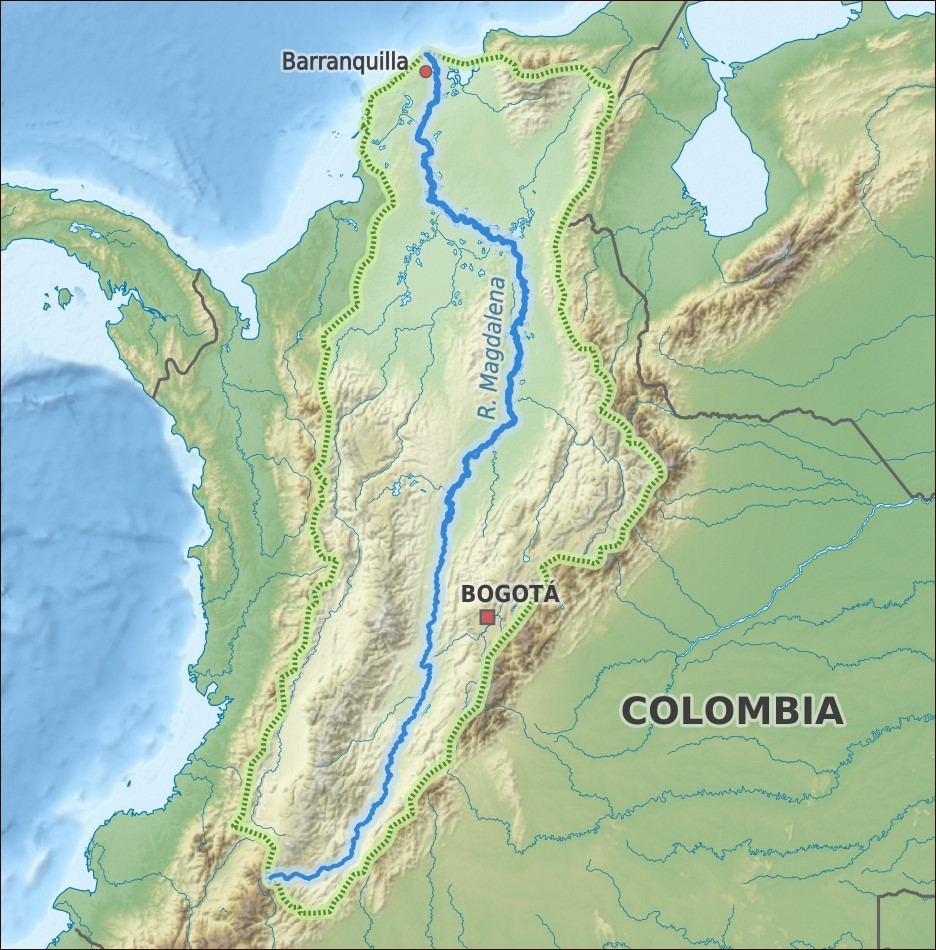

## Librerias Necesarias

In [473]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from tensorflow import keras

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

## Errores
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Dataset

In [474]:
import pandas as pd

# URL del archivo CSV en GitHub
url = 'https://raw.githubusercontent.com/aapineda/data/main/Q_Station_29037020.csv' ##CALAMAR
#url = 'https://raw.githubusercontent.com/aapineda/data/main/Q_Station_21237020.csv'
#url = 'https://raw.githubusercontent.com/aapineda/data/main/Q_Station_25027020.csv'



# Leer el archivo CSV desde la URL
df = pd.read_csv(url)

In [475]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13515 entries, 0 to 13514
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    13515 non-null  object 
 1   Flow    13515 non-null  float64
 2   ENSO    13515 non-null  float64
dtypes: float64(2), object(1)
memory usage: 316.9+ KB


In [476]:
df['Flow'].interpolate(method='linear', inplace=True)

In [477]:
df.head()

,Date,Flow,ENSO
0,1-01-1984,7803.0,-0.6
1,2-01-1984,7718.0,-0.6
2,3-01-1984,7634.0,-0.6
3,4-01-1984,7554.0,-0.6
4,5-01-1984,7498.0,-0.6


In [478]:
df.describe()

,Flow,ENSO
count,13515.000000,13515.000000
mean,7239.553703,-0.003492
std,2708.667922,0.850624
min,2011.900000,-1.800000
25%,5177.200000,-0.600000
50%,6987.000000,-0.100000
75%,9157.050000,0.500000
max,14909.000000,2.600000


In [479]:
df.isnull().sum()

Date    0
Flow    0
ENSO    0
dtype: int64

In [480]:
(df.isnull().sum()/(len(df)))*100

Date    0.0
Flow    0.0
ENSO    0.0
dtype: float64

In [481]:

# Asegúrate de que la columna 'fecha' sea de tipo datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')


# Agrupa los datos por mes y calcula el promedio
serie = df.groupby(df['Date'].dt.to_period('M')).mean()
#serie = df

serie = serie.reset_index(drop=True)

# La variable promedio_por_mes ahora contiene el promedio de 'valor' por mes
print(serie)

             Flow  ENSO
0     7046.387097  -0.6
1     5769.344828  -0.4
2     5016.483871  -0.3
3     4613.266667  -0.4
4     6783.838710  -0.5
..            ...   ...
439   7277.535484  -0.6
440   8679.066667  -0.9
441   9349.567742  -1.2
442   9804.350000  -1.3
443  10353.732258  -1.2

[444 rows x 2 columns]


In [482]:
serie

,Flow,ENSO
0,7046.387097,-0.6
1,5769.344828,-0.4
2,5016.483871,-0.3
3,4613.266667,-0.4
4,6783.838710,-0.5
...,...,...
439,7277.535484,-0.6
440,8679.066667,-0.9
441,9349.567742,-1.2
442,9804.350000,-1.3


In [483]:
serie['Mes'] = range(1, len(serie) + 1) #PREDECIR CON MESES
#serie = serie.drop(columns='Date')

In [484]:
serie

,Flow,ENSO,Mes
0,7046.387097,-0.6,1
1,5769.344828,-0.4,2
2,5016.483871,-0.3,3
3,4613.266667,-0.4,4
4,6783.838710,-0.5,5
...,...,...,...
439,7277.535484,-0.6,440
440,8679.066667,-0.9,441
441,9349.567742,-1.2,442
442,9804.350000,-1.3,443


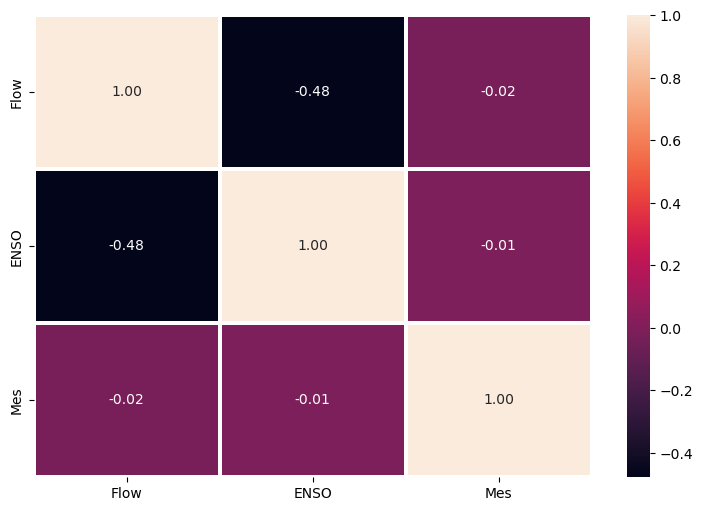

In [485]:
corr = serie.corr()

f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

### Relacion entre ENSO y Caudal

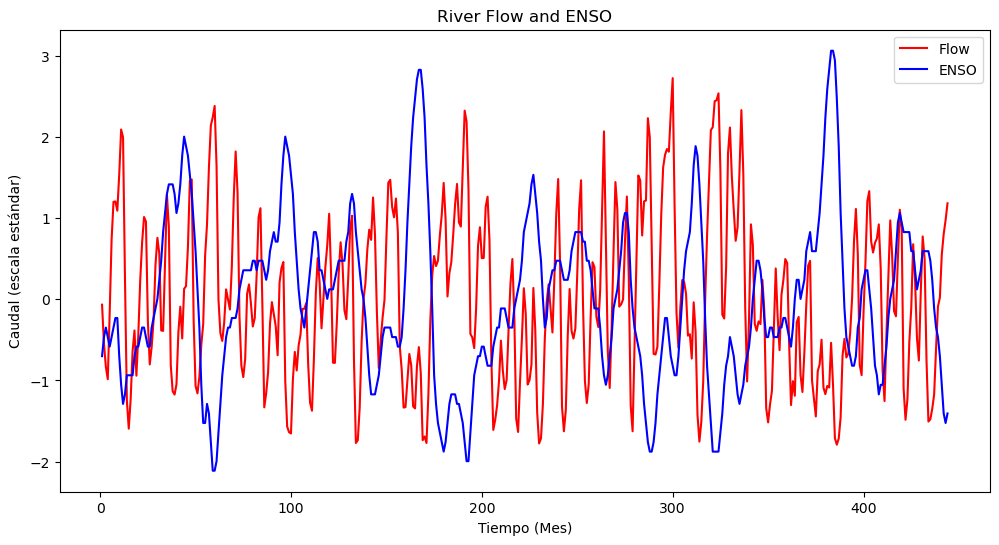

In [486]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  # Importa StandardScaler desde sklearn.preprocessing si no está ya importado

# Escala las series 'Flow' y 'ENSO' usando StandardScaler
scaler = StandardScaler()
scaled_flow = scaler.fit_transform(serie[['Flow']])
scaled_enso = scaler.fit_transform(serie[['ENSO']])

# Crea una figura y traza las series
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(serie['Mes'], scaled_flow, color='red', label='Flow')
ax.plot(serie['Mes'], scaled_enso, color='blue', label='ENSO')  # Usamos un color diferente (azul) para ENSO
ax.set_xlabel('Tiempo (Mes)')
ax.set_ylabel('Caudal (escala estándar)')
ax.legend()
ax.set_title('River Flow and ENSO')
ax.tick_params(axis='x', rotation=0)  # Rotate x-axis labels for readability
plt.show()


#### Lag a los datos

In [487]:
serie['Flow_lag'] = serie['Flow'].shift(1)
serie['ENSO_lag'] = serie['ENSO'].shift(1)

In [488]:
serie

,Flow,ENSO,Mes,Flow_lag,ENSO_lag
0,7046.387097,-0.6,1,NaN,NaN
1,5769.344828,-0.4,2,7046.387097,-0.6
2,5016.483871,-0.3,3,5769.344828,-0.4
3,4613.266667,-0.4,4,5016.483871,-0.3
4,6783.838710,-0.5,5,4613.266667,-0.4
...,...,...,...,...,...
439,7277.535484,-0.6,440,6987.390323,-0.4
440,8679.066667,-0.9,441,7277.535484,-0.6
441,9349.567742,-1.2,442,8679.066667,-0.9
442,9804.350000,-1.3,443,9349.567742,-1.2


In [489]:
serie.at[0, 'Flow_lag'] = 7490.387
#serie.at[0, 'ENSO_lag'] = -0.8
#serie.at[1, 'ENSO_lag'] = -1
serie.at[0, 'ENSO_lag'] = -0.9



In [490]:
serie

,Flow,ENSO,Mes,Flow_lag,ENSO_lag
0,7046.387097,-0.6,1,7490.387000,-0.9
1,5769.344828,-0.4,2,7046.387097,-0.6
2,5016.483871,-0.3,3,5769.344828,-0.4
3,4613.266667,-0.4,4,5016.483871,-0.3
4,6783.838710,-0.5,5,4613.266667,-0.4
...,...,...,...,...,...
439,7277.535484,-0.6,440,6987.390323,-0.4
440,8679.066667,-0.9,441,7277.535484,-0.6
441,9349.567742,-1.2,442,8679.066667,-0.9
442,9804.350000,-1.3,443,9349.567742,-1.2


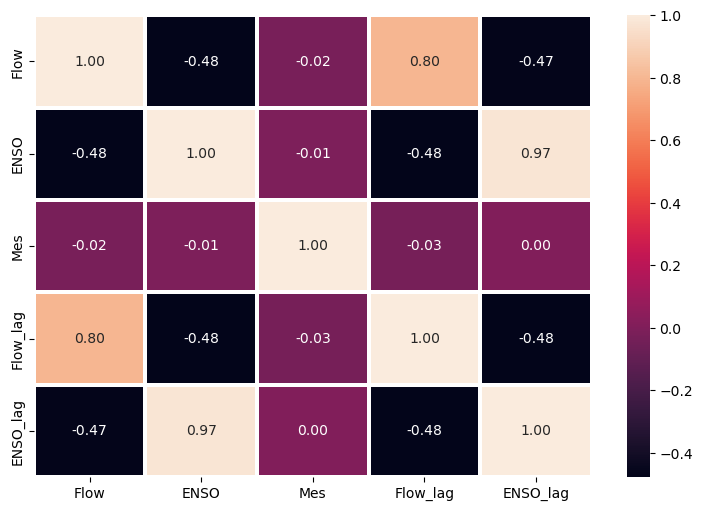

In [491]:
corr = serie.corr()

f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

In [492]:
serie_ARIMA= serie[['Flow', 'Mes']].copy()


In [493]:
serie_ARIMA

,Flow,Mes
0,7046.387097,1
1,5769.344828,2
2,5016.483871,3
3,4613.266667,4
4,6783.838710,5
...,...,...
439,7277.535484,440
440,8679.066667,441
441,9349.567742,442
442,9804.350000,443


### Auto Correlation function (ACF) and Partial Autocorrelation Funcion(PACF).

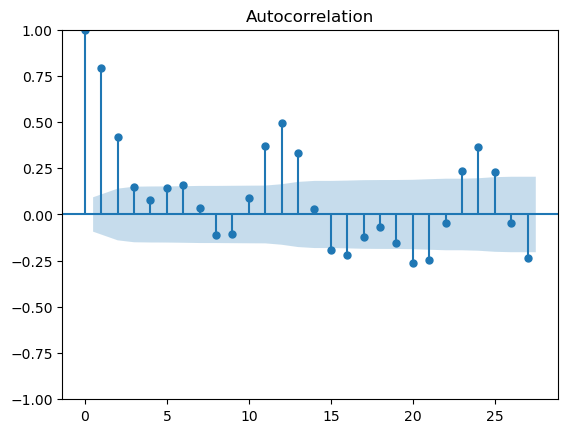

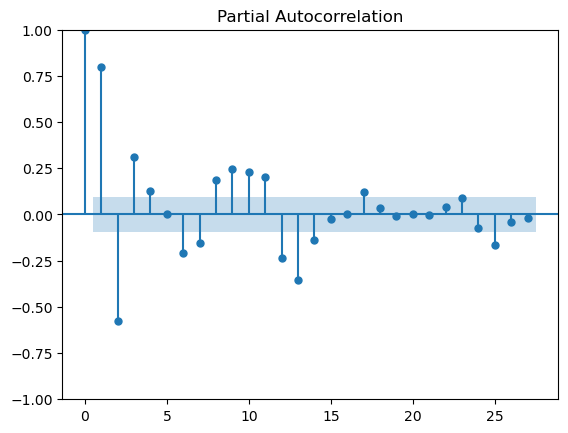

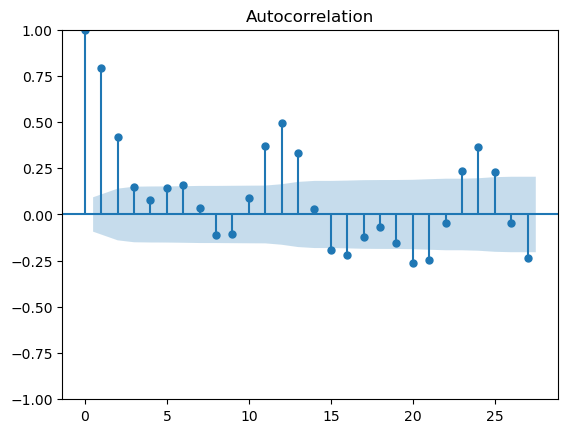

In [494]:
plot_pacf(serie_ARIMA['Flow'])
plot_acf(serie_ARIMA['Flow'])

In [495]:
#Function to know stacionality

def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios (Stationary)")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos son no estacionarios (Non Stationary)")

In [496]:
Prueba_Dickey_Fuller(serie_ARIMA['Flow'],"Flow")

Resultados de la prueba de Dickey-Fuller para columna: Flow
Test Statistic                         -5.555584
p-value                                 0.000002
No Lags Used                           13.000000
Número de observaciones utilizadas    430.000000
Critical Value (1%)                    -3.445649
Critical Value (5%)                    -2.868285
Critical Value (10%)                   -2.570363
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios (Stationary)


In [497]:
# Convertir 'Flow' y 'Mes' en arreglos NumPy y luego aplicar reshape
"""target = serie['Flow'].values.reshape(-1, 1)
data = serie['Mes'].values.reshape(-1, 1)"""

"target = serie['Flow'].values.reshape(-1, 1)\ndata = serie['Mes'].values.reshape(-1, 1)"

### Datos de Entrenamiento y Prueba

In [498]:
size = int(len(serie) * 0.8)

In [499]:
data_train = serie[serie.Mes <= size]
data_test  = serie[serie.Mes > size]

In [500]:
#X_train = np.array(data_train.Mes)[:, None] # vector-columna

#X_train = np.array(data_train[['Mes', 'ENSO']])
#X_train = np.array(data_train[['Flow_lag']])
X_train = np.array(data_train[['Flow_lag', 'ENSO_lag']])

y_train = np.array(data_train.Flow)

#X_test = np.array(data_test.Mes)[:, None] # vector-columna
X_test = np.array(data_test[['Flow_lag', 'ENSO_lag']])
y_test = np.array(data_test.Flow)

X_all = np.array(serie[['Flow_lag', 'ENSO_lag']])


## Metricas

Aqui se determinan las metricas de interes para el estudio.

In [501]:
def metricas(y_test, y_pred, modelo):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rrmse = np.sqrt(np.mean((y_test - y_pred) ** 2)) / np.mean(y_test)
    r2 = r2_score(y_test, y_pred)
    nse = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

    # Crear un diccionario con los resultados
    resultados = {
        'Modelo': modelo,
        'MAE': '{:.3f}'.format(mae),
        'RRMSE': '{:.3f}'.format(rrmse),
        'R-squared (R^2)': '{:.3f}'.format(r2),
        'NSE (Nash-Sutcliffe Efficiency)': '{:.3f}'.format(nse)
    }


    # Crear un DataFrame a partir del diccionario
    df_resultados = pd.DataFrame([resultados])

    return df_resultados


columnas = ['Modelo', 'MAE', 'RRMSE', 'R-squared (R^2)', 'NSE (Nash-Sutcliffe Efficiency)']
df_resultados = pd.DataFrame(columns=columnas)

## ARIMA

In [502]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

# Load dataset

# Split into train and test sets
X = serie_ARIMA['Flow'].values
train, test = X[:size], X[size:]



## Funcion ARIMA

In [503]:

def ARIMA_estimador(serie_ARIMA, orden):
    # Split into train and test sets
    predictions = []
    residuales = []
    X = serie_ARIMA['Flow'].values
    size = int(len(X) * 0.8)
    train, test = X[:size], X[size:]

    history = [x for x in train]
    
    # Walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=orden)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('Month=%s, Predicted=%f, Expected=%f' % (serie_ARIMA['Mes'].iloc[size + t], yhat, obs))

    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=orden)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        residuales.append(obs-yhat)

    fig = plt.figure(figsize=(12, 6))
    plt.plot(serie_ARIMA['Mes'].iloc[size:], test, marker='o', linestyle='', label='Actual')
    plt.plot(serie_ARIMA['Mes'].iloc[size:], predictions, color='red', label='Predicted')
    plt.xlabel('Tiempo (Mes)')
    plt.ylabel('Caudal (m3/s)')
    plt.legend()
    plt.title('River Flow Forecast')
    plt.xticks(rotation=0)
    plt.show()


    # Evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)

    # Plot forecasts against actual outcomes
    fig = plt.figure(figsize=(12, 6))
    plt.plot(serie_ARIMA['Mes'].iloc[size:], residuales, color='red', label='Residuales')
    plt.xlabel('Tiempo (Mes)')
    plt.ylabel('Caudal (m3/s)')
    plt.legend()
    plt.title('Residuales obtenidos')
    plt.xticks(rotation=0)  # Rotate x-axis labels for readability
    plt.show()
    
    
    return predictions, residuales


## Modelos lineales
Entre los modelos lineales se encuentran: autoregressive (AR), moving average (MA), and autoregressive moving average (ARMA)

### AR

In [504]:
import pmdarima as pm

model_1 = pm.auto_arima(X, start_p=1, start_q=0,
                      test='adf',
                      max_p=5, max_q=0,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model_1.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7865.329, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9208.012, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=7777.791, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=7662.598, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=7641.101, Time=0.15 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=7639.764, Time=0.17 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=7603.639, Time=0.17 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=7601.648, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=7606.573, Time=0.11 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 0.983 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  444
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -3794.824
Date:                Thu, 05 Oct 2023   AIC      

* Se ajusta el orden de AR.

In [505]:
orden_ar=(5, 0, 0) 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  355
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -3036.744
Date:                Thu, 05 Oct 2023   AIC                           6087.488
Time:                        10:16:54   BIC                           6114.593
Sample:                             0   HQIC                          6098.271
                                - 355                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7413.0301    367.764     20.157      0.000    6692.227    8133.834
ar.L1          1.4205      0.057     24.728      0.000       1.308       1.533
ar.L2         -0.8886      0.095     -9.400      0.0

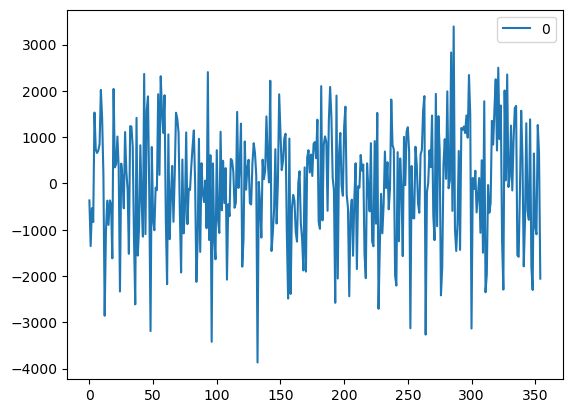

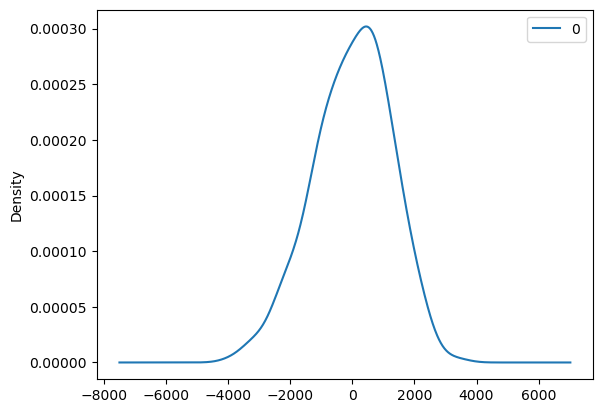

                 0
count   355.000000
mean     -5.996724
std    1254.328712
min   -3866.216294
25%    -843.690613
50%      66.530668
75%     869.953976
max    3390.829384


In [506]:
# fit model
model = ARIMA(train, order=orden_ar)
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

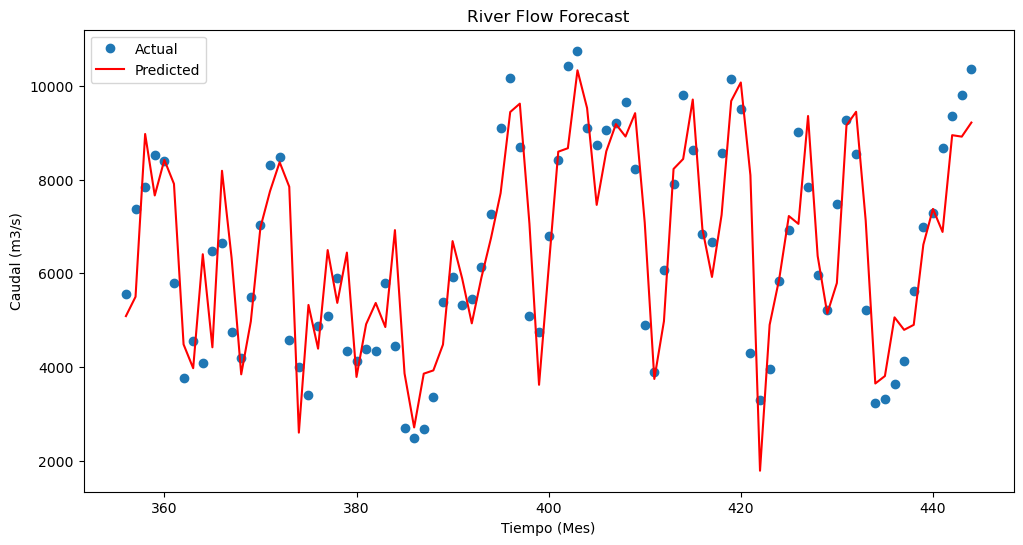

Test RMSE: 1216.840


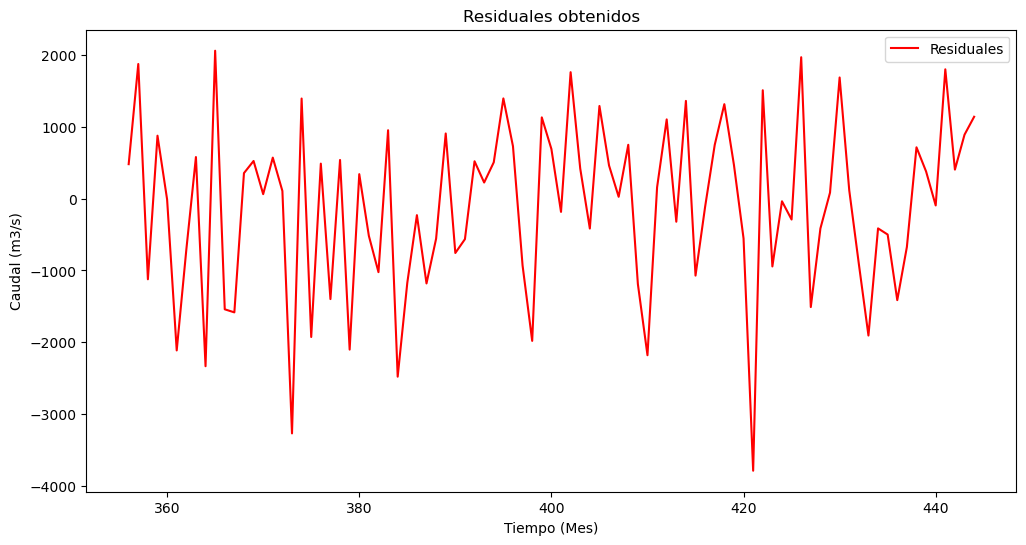

In [507]:
predictions = []
residuales = []

predictions_AR, residuales_AR = ARIMA_estimador(serie_ARIMA, orden_ar)

##### Metricas del modelo

In [508]:
nueva_fila = metricas(y_test, predictions_AR, 'AR')
df_resultados = df_resultados.append(nueva_fila, ignore_index=True)
print(df_resultados)

  Modelo      MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR  968.170  0.188           0.697                           0.697


### ARMA

In [509]:
import pmdarima as pm

model_1 = pm.auto_arima(X, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model_1.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7727.800, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9208.012, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7865.329, Time=0.02 sec


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7724.921, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=7777.791, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=7640.387, Time=0.31 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=7662.598, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=7641.410, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=7605.115, Time=0.57 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=7555.287, Time=0.65 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=7557.978, Time=0.66 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=7560.305, Time=0.76 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=7525.067, Time=0.86 sec
 ARIMA(5,0,4)(0,0,0)[0]            

In [510]:
orden_arma=(4, 0, 5)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  355
Model:                 ARIMA(4, 0, 5)   Log Likelihood               -2994.444
Date:                Thu, 05 Oct 2023   AIC                           6010.888
Time:                        10:17:39   BIC                           6053.481
Sample:                             0   HQIC                          6027.833
                                - 355                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7413.0299    331.599     22.355      0.000    6763.108    8062.952
ar.L1          0.7041      0.056     12.573      0.000       0.594       0.814
ar.L2         -0.0188      0.043     -0.435      0.6

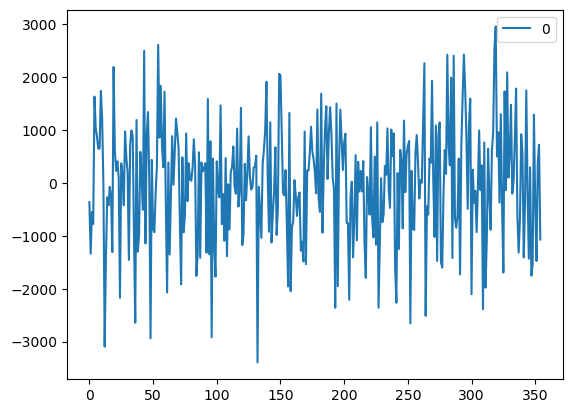

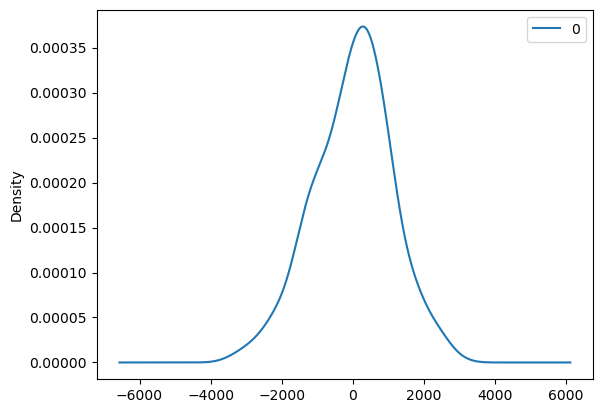

                 0
count   355.000000
mean     -4.287279
std    1111.009218
min   -3393.343477
25%    -750.142151
50%      96.921767
75%     712.506416
max    2951.812142


In [511]:
# fit model
model = ARIMA(train, order=orden_arma)
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [512]:
serie_ARIMA

,Flow,Mes
0,7046.387097,1
1,5769.344828,2
2,5016.483871,3
3,4613.266667,4
4,6783.838710,5
...,...,...
439,7277.535484,440
440,8679.066667,441
441,9349.567742,442
442,9804.350000,443


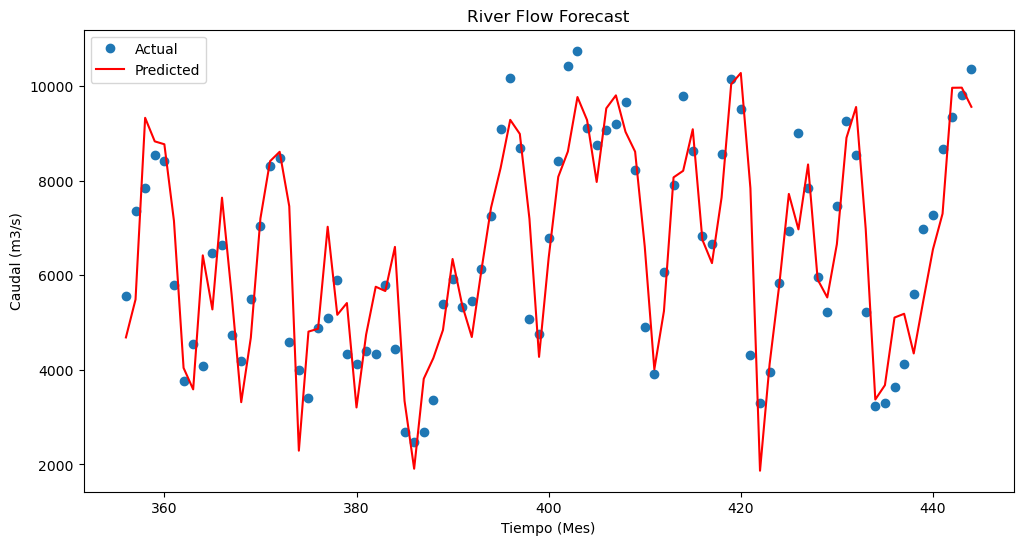

Test RMSE: 1090.249


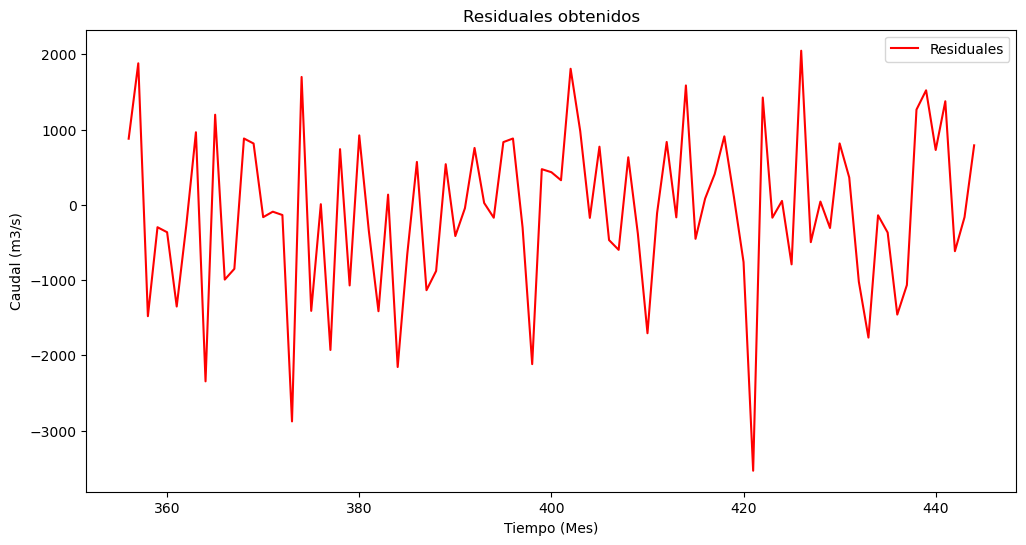

In [513]:
predictions_ARMA, residuales_ARMA = ARIMA_estimador(serie_ARIMA, orden_arma)

##### Metricas del modelo

In [514]:
nueva_fila = metricas(y_test, predictions_ARMA, 'ARMA')
df_resultados = df_resultados.append(nueva_fila, ignore_index=True)
print(df_resultados)

  Modelo      MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR  968.170  0.188           0.697                           0.697
1   ARMA  848.461  0.169           0.757                           0.757


## Ridge

In [515]:
from sklearn.linear_model import Ridge

alpha_values = np.logspace(-1, 1, 100)  # Generates values from 1e-6 to 1e6 with 13 points

# Definir el conjunto de hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    'ridge__alpha': alpha_values,
}

# Crear el pipeline con MinMaxScaler y Ridge
pipe = make_pipeline(MinMaxScaler(), Ridge())

# Realizar la búsqueda en cuadrícula
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 1

In [516]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridge', Ridge(alpha=0.30538555088334157))])


In [517]:
y_pred = grid.predict(X_test)
print("Training-set score: {:.2f}".format(grid.score(X_train, y_train)))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))


Training-set score: 0.64
Test-set score: 0.59


##### Metricas del modelo

In [518]:
nueva_fila = metricas(y_test, y_pred, 'Ridge')
df_resultados = df_resultados.append(nueva_fila, ignore_index=True)
print(df_resultados)

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   848.461  0.169           0.757                           0.757
2  Ridge  1131.050  0.220           0.587                           0.587


## Lasso

In [519]:
from sklearn.linear_model import Lasso

alpha_values = np.logspace(-1, 1, 100)  # Generates values from 1e-6 to 1e6 with 13 points

# Definir el conjunto de hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    'lasso__alpha': alpha_values,
}

# Crear el pipeline con MinMaxScaler y Lasso
pipe = make_pipeline(MinMaxScaler(), Lasso())

# Realizar la búsqueda en cuadrícula
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 1

In [520]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('lasso', Lasso(alpha=0.11497569953977356))])


In [521]:
y_pred = grid.predict(X_test)
print("Training-set score: {:.2f}".format(grid.score(X_train, y_train)))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Training-set score: 0.64
Test-set score: 0.59


##### Metricas del modelo

In [522]:
nueva_fila = metricas(y_test, y_pred, 'Lasso')
df_resultados = df_resultados.append(nueva_fila, ignore_index=True)
print(df_resultados)

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   848.461  0.169           0.757                           0.757
2  Ridge  1131.050  0.220           0.587                           0.587
3  Lasso  1130.720  0.220           0.586                           0.586


## Random Forest

In [523]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [524]:
pipe = make_pipeline(StandardScaler(), RandomForestRegressor())
param_grid = {'randomforestregressor__max_depth': [2,3,4],
              'randomforestregressor__n_estimators': [400],
              'randomforestregressor__max_leaf_nodes': [2,4,6,8],
              'randomforestregressor__min_samples_split': [2,5,10,15]}

RF = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)
RF.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [2, 3, 4],
                         'randomforestregressor__max_leaf_nodes': [2, 4, 6, 8],
                         'randomforestregressor__min_samples_split': [2, 5, 10,
                                                                      15],
                         'randomforestregressor__n_estimators': [400]},
             scoring='r2')

In [525]:
print("Best estimator:\n{}".format(RF.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=3, max_leaf_nodes=8,
                                       min_samples_split=15,
                                       n_estimators=400))])


In [526]:
print("Training-set score: {:.2f}".format(RF.score(X_train, y_train)))
print("Test-set score: {:.2f}".format(RF.score(X_test, y_test)))


Training-set score: 0.68
Test-set score: 0.53


In [527]:
y_pred = RF.predict(X_test)

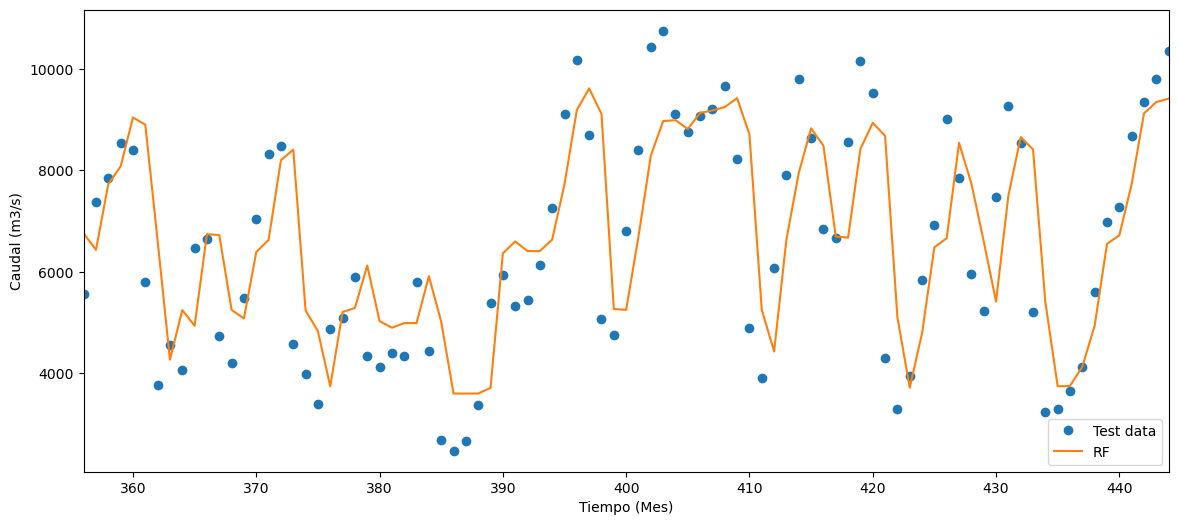

In [528]:
fig = plt.figure(figsize=(14, 6))
plt.plot(data_test.Mes, y_test, marker='o', linestyle='', label="Test data")
plt.plot(data_test.Mes, y_pred, label="RF")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Agregamos nombres a los ejes
plt.xlabel("Tiempo (Mes)")  # Nombre del eje x
plt.ylabel("Caudal (m3/s)")  # Nombre del eje y

plt.xlim(data_test.Mes.min(), data_test.Mes.max())

plt.show()

##### Metricas del modelo

In [529]:
nueva_fila = metricas(y_test, y_pred, 'RF')
df_resultados = df_resultados.append(nueva_fila, ignore_index=True)
print(df_resultados)

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   848.461  0.169           0.757                           0.757
2  Ridge  1131.050  0.220           0.587                           0.587
3  Lasso  1130.720  0.220           0.586                           0.586
4     RF  1167.635  0.233           0.534                           0.534


## k-NN regresor

In [530]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor

In [531]:
pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())

In [532]:
param_grid = {'kneighborsregressor__n_neighbors': [1,2,4,6,8,10,15,20,30,40]}

In [533]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             param_grid={'kneighborsregressor__n_neighbors': [1, 2, 4, 6, 8, 10,
                                                              15, 20, 30, 40]},
             scoring='r2')

In [534]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=15))])


In [535]:
y_pred = grid.predict(X_test)

In [536]:
print("Training-set score: {:.2f}".format(grid.score(X_train, y_train)))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Training-set score: 0.66
Test-set score: 0.53


##### Metricas del modelo

In [537]:
nueva_fila = metricas(y_test, y_pred, 'k-NN')
df_resultados = df_resultados.append(nueva_fila, ignore_index=True)
print(df_resultados)

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   848.461  0.169           0.757                           0.757
2  Ridge  1131.050  0.220           0.587                           0.587
3  Lasso  1130.720  0.220           0.586                           0.586
4     RF  1167.635  0.233           0.534                           0.534
5   k-NN  1174.654  0.234           0.531                           0.531


## SVR

In [538]:
from sklearn.svm import SVR

In [539]:
param_grid = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svr__epsilon': [0.001, 0.01,0.1, 0.2, 0.5, 1]
}

In [540]:
pipe = make_pipeline(MinMaxScaler(), SVR())

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'svr__epsilon': [0.001, 0.01, 0.1, 0.2, 0.5, 1],
                         'svr__kernel': ['linear', 'rbf']},
             scoring='r2')

In [541]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svr', SVR(C=100, epsilon=0.001))])


In [542]:
y_pred = grid.predict(X_test)

##### Metricas del modelo

In [543]:
nueva_fila = metricas(y_test, y_pred, 'SVR')
df_resultados = df_resultados.append(nueva_fila, ignore_index=True)
print(df_resultados)

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   848.461  0.169           0.757                           0.757
2  Ridge  1131.050  0.220           0.587                           0.587
3  Lasso  1130.720  0.220           0.586                           0.586
4     RF  1167.635  0.233           0.534                           0.534
5   k-NN  1174.654  0.234           0.531                           0.531
6    SVR  1303.934  0.251           0.461                           0.461


## Redes Neuronales

In [544]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

In [545]:
# Define el callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Epoch 1/200
3/3 [==============================] - 1s 90ms/step - loss: 53324904.0000 - val_loss: 59611336.0000
Epoch 2/200
3/3 [==============================] - 0s 16ms/step - loss: 38760596.0000 - val_loss: 41228824.0000
Epoch 3/200
3/3 [==============================] - 0s 16ms/step - loss: 26598794.0000 - val_loss: 25545674.0000
Epoch 4/200
3/3 [==============================] - 0s 14ms/step - loss: 16390880.0000 - val_loss: 14446713.0000
Epoch 5/200
1/3 [=========>....................] - ETA: 0s - loss: 10152254.0000

3/3 [==============================] - 0s 19ms/step - loss: 9131818.0000 - val_loss: 6992348.0000
Epoch 6/200
3/3 [==============================] - 0s 15ms/step - loss: 4615741.5000 - val_loss: 3691878.7500
Epoch 7/200
3/3 [==============================] - 0s 17ms/step - loss: 2859785.7500 - val_loss: 4053361.2500
Epoch 8/200
3/3 [==============================] - 0s 22ms/step - loss: 3518352.5000 - val_loss: 5933273.0000
Epoch 9/200
3/3 [==============================] - 0s 15ms/step - loss: 4679192.5000 - val_loss: 6433238.0000
Epoch 10/200
3/3 [==============================] - 0s 12ms/step - loss: 4708230.0000 - val_loss: 5258169.0000
Epoch 11/200
3/3 [==============================] - 0s 13ms/step - loss: 3815677.2500 - val_loss: 3950197.7500
Epoch 12/200
3/3 [==============================] - 0s 12ms/step - loss: 3022596.5000 - val_loss: 3476601.2500
Epoch 13/200
3/3 [==============================] - 0s 12ms/step - loss: 2844106.2500 - val_loss: 3636474.2500
Epoch 14/200
3/3 [

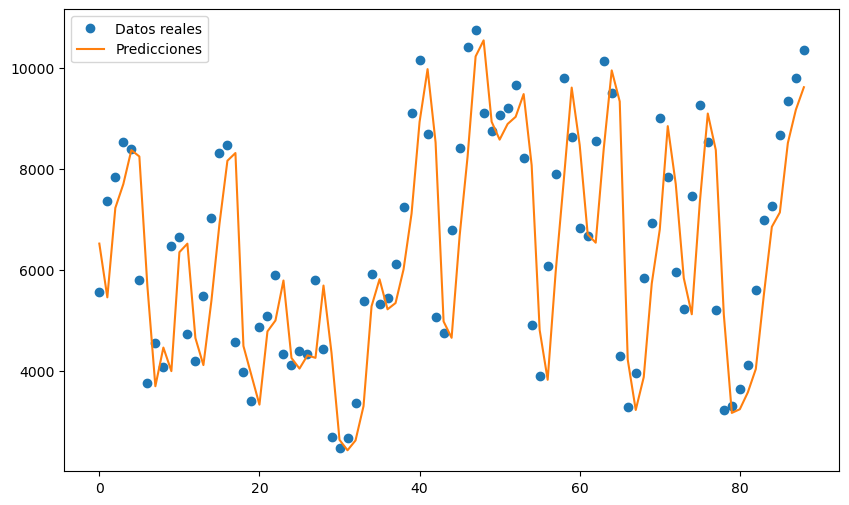

In [546]:
# Define el modelo de red neuronal
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1])),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)
])

# Compila el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

indice = int(0.8 * len(X_train))

X_trainval = X_train[:indice]
y_trainval = y_train[:indice]
X_val = X_train[indice:]
y_val = y_train[indice:]

scaler = MinMaxScaler()


model.fit(X_trainval, y_trainval, epochs=200,
                        batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])


# Evalúa el modelo en datos de prueba
y_pred = model.predict(X_test)
y_pred = y_pred.flatten().tolist()



# Grafica los resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Datos reales', marker='o', linestyle='' )
plt.plot(y_pred, label='Predicciones')
plt.legend()
plt.show()


##### Metricas del modelo

In [547]:
nueva_fila = metricas(y_test, y_pred, 'MLP')
df_resultados = df_resultados.append(nueva_fila, ignore_index=True)
print(df_resultados)

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   848.461  0.169           0.757                           0.757
2  Ridge  1131.050  0.220           0.587                           0.587
3  Lasso  1130.720  0.220           0.586                           0.586
4     RF  1167.635  0.233           0.534                           0.534
5   k-NN  1174.654  0.234           0.531                           0.531
6    SVR  1303.934  0.251           0.461                           0.461
7    MLP  1237.249  0.238           0.514                           0.514


## Modelo Hibrido


### Random Forest con modelos lineales 
Entre los modelos lineales se encuentran: autoregressive (AR), moving average (MA), and autoregressive moving average (ARMA)

Para medir el rendimiento de todos los modelos desarrollados de manera cualitativa, los valores de RRMSE (Error Cuadrático Medio Raíz Relativo) se categorizaron de la siguiente manera:
* Excelente: 0% < RRMSE < 10%
* Bueno: 10% < RRMSE < 20%
* Regular: 20% < RRMSE < 30%
* Malo: RRMSE > 30%


### AR-RF

In [548]:
residuales_test_lag = np.roll(residuales_AR, shift=1)
residuales_test_extra = np.column_stack((residuales_test_lag, X_test[:, 1]))
#residuales_test_extra = residuales_test_lag


Text(0, 0.5, 'Caudal (m3/s)')

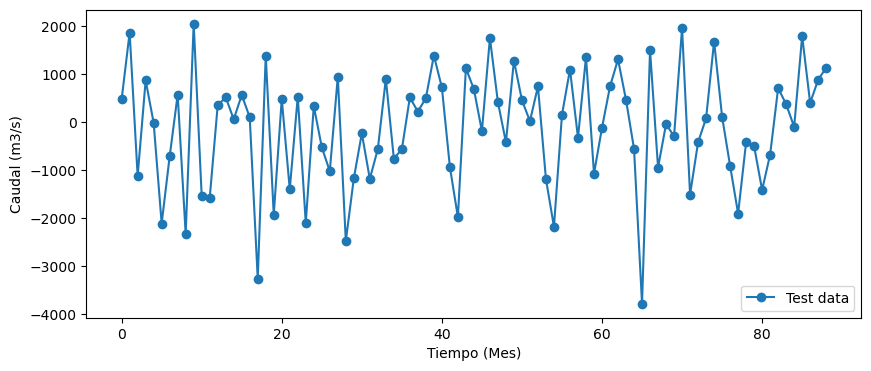

In [549]:
fig = plt.figure(figsize=(10, 4))
plt.plot(residuales_AR, marker='o', label="Test data")
#plt.plot(data_test.Mes, y_pred, label="RF")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Agregamos nombres a los ejes
plt.xlabel("Tiempo (Mes)")  # Nombre del eje x
plt.ylabel("Caudal (m3/s)")  # Nombre del eje y


In [550]:
best_order = orden_ar
history = [x for x in train]
model = ARIMA(history, order=best_order)
model_fit = model.fit()

residuals_train = model_fit.resid

residuales_train_lag = np.roll(residuals_train, shift=1)
#residuales_train_extra = residuales_train_lag
residuales_train_extra = np.column_stack((residuales_train_lag, X_train[:, 1]))

Text(0, 0.5, 'Caudal (m3/s)')

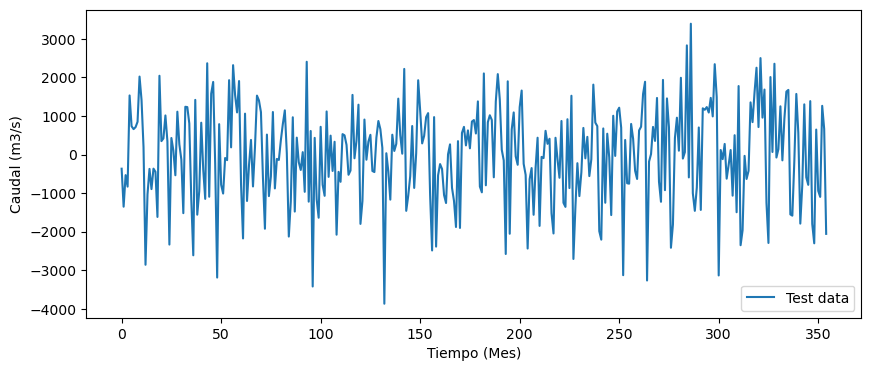

In [551]:
fig = plt.figure(figsize=(10, 4))
plt.plot(residuals_train, label="Test data")
#plt.plot(data_test.Mes, y_pred, label="RF")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Agregamos nombres a los ejes
plt.xlabel("Tiempo (Mes)")  # Nombre del eje x
plt.ylabel("Caudal (m3/s)")  # Nombre del eje y



In [552]:
pipe = make_pipeline(StandardScaler(), RandomForestRegressor())
param_grid = {'randomforestregressor__max_depth': [2,3,4],
              'randomforestregressor__n_estimators': [400],
              'randomforestregressor__max_leaf_nodes': [2,4,6,8],
              'randomforestregressor__min_samples_split': [2,5,10,15]}

RF_e = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)
RF_e.fit(residuales_train_extra, residuals_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [2, 3, 4],
                         'randomforestregressor__max_leaf_nodes': [2, 4, 6, 8],
                         'randomforestregressor__min_samples_split': [2, 5, 10,
                                                                      15],
                         'randomforestregressor__n_estimators': [400]},
             scoring='r2')

In [553]:
print("Best estimator:\n{}".format(RF_e.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=2, max_leaf_nodes=8,
                                       min_samples_split=15,
                                       n_estimators=400))])


In [554]:
y_pred = RF_e.predict(residuales_test_extra)

In [555]:
"""plt.figure(figsize=(14,6))
plt.plot(residuals_train, label="Training data")
#plt.plot(residuales_AR, label="Test data")
plt.plot(y_tree, label="Tree prediction")
plt.legend();

"""

'plt.figure(figsize=(14,6))\nplt.plot(residuals_train, label="Training data")\n#plt.plot(residuales_AR, label="Test data")\nplt.plot(y_tree, label="Tree prediction")\nplt.legend();\n\n'

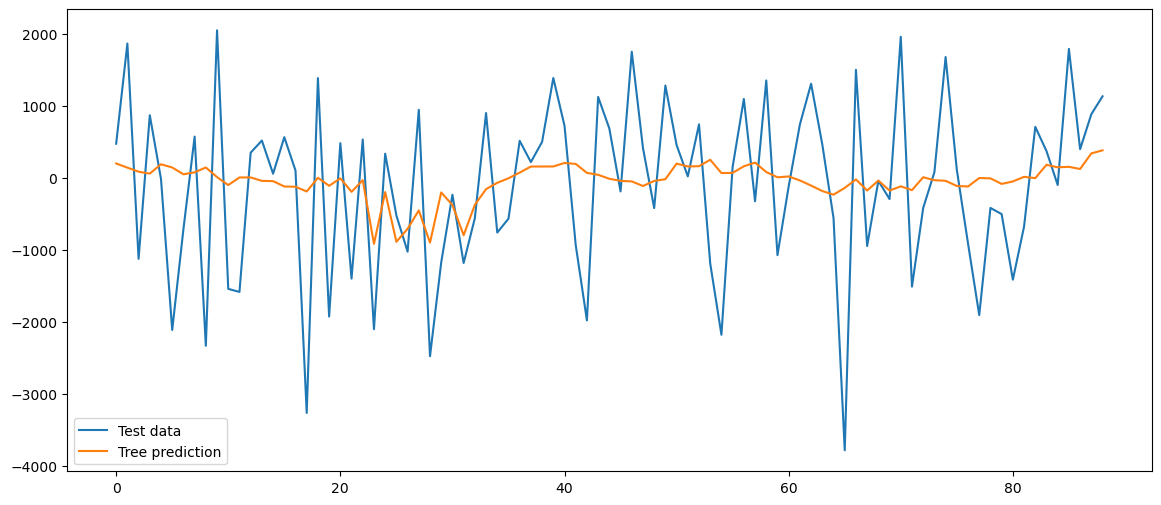

In [556]:
plt.figure(figsize=(14,6))
plt.plot(residuales_AR, label="Test data")
plt.plot(y_pred, label="Tree prediction")
plt.legend();


In [557]:
print("Training-set score: {:.2f}".format(RF_e.score(residuales_train_extra, residuals_train)))
print("Test-set score: {:.2f}".format(RF_e.score(residuales_test_extra, residuales_AR)))


Training-set score: 0.10
Test-set score: 0.09


In [558]:
y_residual = RF_e.predict(residuales_test_extra)

y_AR_RF = predictions_AR + y_residual


##### Metricas del modelo

In [559]:
nueva_fila = metricas(test, y_AR_RF, 'AR-RF')
df_resultados = df_resultados.append(nueva_fila, ignore_index=True)
print(df_resultados)

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   848.461  0.169           0.757                           0.757
2  Ridge  1131.050  0.220           0.587                           0.587
3  Lasso  1130.720  0.220           0.586                           0.586
4     RF  1167.635  0.233           0.534                           0.534
5   k-NN  1174.654  0.234           0.531                           0.531
6    SVR  1303.934  0.251           0.461                           0.461
7    MLP  1237.249  0.238           0.514                           0.514
8  AR-RF   906.356  0.179           0.726                           0.726


### ARMA-RF

In [560]:
residuales_test_lag = np.roll(residuales_ARMA, shift=1)
residuales_test_extra = np.column_stack((residuales_test_lag, X_test[:, 1]))

Text(0, 0.5, 'Caudal (m3/s)')

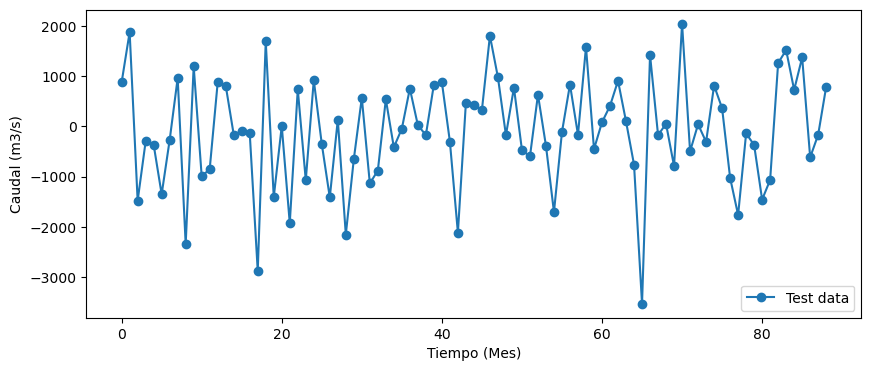

In [561]:
fig = plt.figure(figsize=(10, 4))
plt.plot(residuales_ARMA, marker='o', label="Test data")
#plt.plot(data_test.Mes, y_pred, label="RF")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Agregamos nombres a los ejes
plt.xlabel("Tiempo (Mes)")  # Nombre del eje x
plt.ylabel("Caudal (m3/s)")  # Nombre del eje y


In [562]:
best_order = orden_arma
history = [x for x in train]
model = ARIMA(history, order=best_order)
model_fit = model.fit()

residuals_train = model_fit.resid

residuales_train_lag = np.roll(residuals_train, shift=1)
#residuales_train_extra = residuales_train_lag
residuales_train_extra = np.column_stack((residuales_train_lag, X_train[:, 1]))

Text(0, 0.5, 'Caudal (m3/s)')

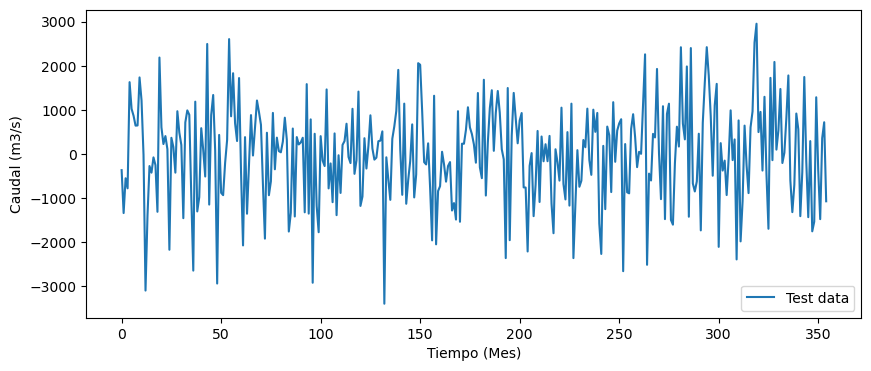

In [563]:
fig = plt.figure(figsize=(10, 4))
plt.plot(residuals_train, label="Test data")
#plt.plot(data_test.Mes, y_pred, label="RF")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Agregamos nombres a los ejes
plt.xlabel("Tiempo (Mes)")  # Nombre del eje x
plt.ylabel("Caudal (m3/s)")  # Nombre del eje y



In [564]:
pipe = make_pipeline(StandardScaler(), RandomForestRegressor())
param_grid = {'randomforestregressor__max_depth': [2,3,4],
              'randomforestregressor__n_estimators': [400],
              'randomforestregressor__max_leaf_nodes': [2,4,6,8],
              'randomforestregressor__min_samples_split': [2,5,10,15]}

RF_e = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)
RF_e.fit(residuales_train_extra, residuals_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [2, 3, 4],
                         'randomforestregressor__max_leaf_nodes': [2, 4, 6, 8],
                         'randomforestregressor__min_samples_split': [2, 5, 10,
                                                                      15],
                         'randomforestregressor__n_estimators': [400]},
             scoring='r2')

In [565]:
print("Best estimator:\n{}".format(RF_e.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=2, max_leaf_nodes=4,
                                       min_samples_split=15,
                                       n_estimators=400))])


In [566]:
y_pred = RF_e.predict(residuales_test_extra)

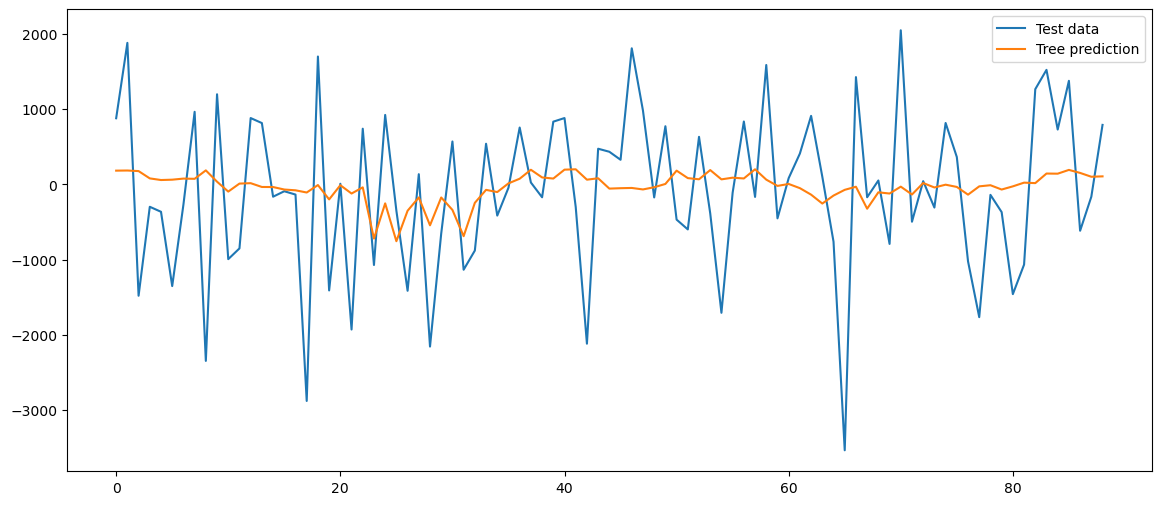

In [567]:
plt.figure(figsize=(14,6))
plt.plot(residuales_ARMA, label="Test data")
plt.plot(y_pred, label="Tree prediction")
plt.legend();


In [568]:
print("Training-set score: {:.2f}".format(RF_e.score(residuales_train_extra, residuals_train)))
print("Test-set score: {:.2f}".format(RF_e.score(residuales_test_extra, residuales_AR)))


Training-set score: 0.10
Test-set score: 0.07


In [569]:
y_ARMA_RF = predictions_ARMA + y_pred

##### Metricas del modelo

In [570]:
nueva_fila = metricas(test, y_ARMA_RF, 'ARMA-RF')
df_resultados = df_resultados.append(nueva_fila, ignore_index=True)
print(df_resultados)

    Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0       AR   968.170  0.188           0.697                           0.697
1     ARMA   848.461  0.169           0.757                           0.757
2    Ridge  1131.050  0.220           0.587                           0.587
3    Lasso  1130.720  0.220           0.586                           0.586
4       RF  1167.635  0.233           0.534                           0.534
5     k-NN  1174.654  0.234           0.531                           0.531
6      SVR  1303.934  0.251           0.461                           0.461
7      MLP  1237.249  0.238           0.514                           0.514
8    AR-RF   906.356  0.179           0.726                           0.726
9  ARMA-RF   825.405  0.163           0.772                           0.772


### AR-MODEL

Text(0, 0.5, 'Caudal (m3/s)')

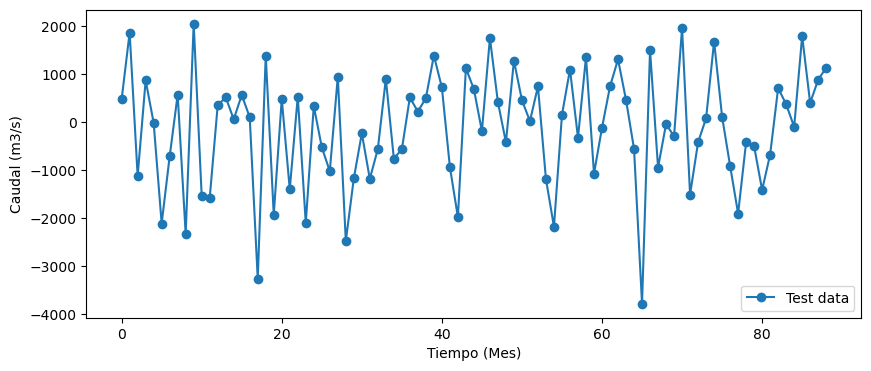

In [571]:
fig = plt.figure(figsize=(10, 4))
plt.plot(residuales_AR, marker='o', label="Test data")
#plt.plot(data_test.Mes, y_pred, label="RF")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Agregamos nombres a los ejes
plt.xlabel("Tiempo (Mes)")  # Nombre del eje x
plt.ylabel("Caudal (m3/s)")  # Nombre del eje y


In [572]:
best_order = orden_ar
history = [x for x in train]
model = ARIMA(history, order=best_order)
model_fit = model.fit()

residuals_train = model_fit.resid

residuales_train_lag = np.roll(residuals_train, shift=1)
#residuales_train_extra = residuales_train_lag
residuales_train_extra = np.column_stack((residuales_train_lag, X_train[:, 1]))

Text(0, 0.5, 'Caudal (m3/s)')

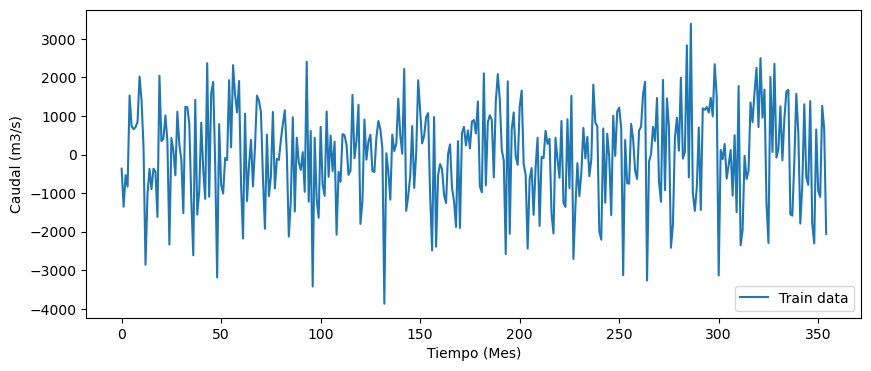

In [573]:
fig = plt.figure(figsize=(10, 4))
plt.plot(residuals_train, label="Train data")
#plt.plot(data_test.Mes, y_pred, label="RF")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Agregamos nombres a los ejes
plt.xlabel("Tiempo (Mes)")  # Nombre del eje x
plt.ylabel("Caudal (m3/s)")  # Nombre del eje y



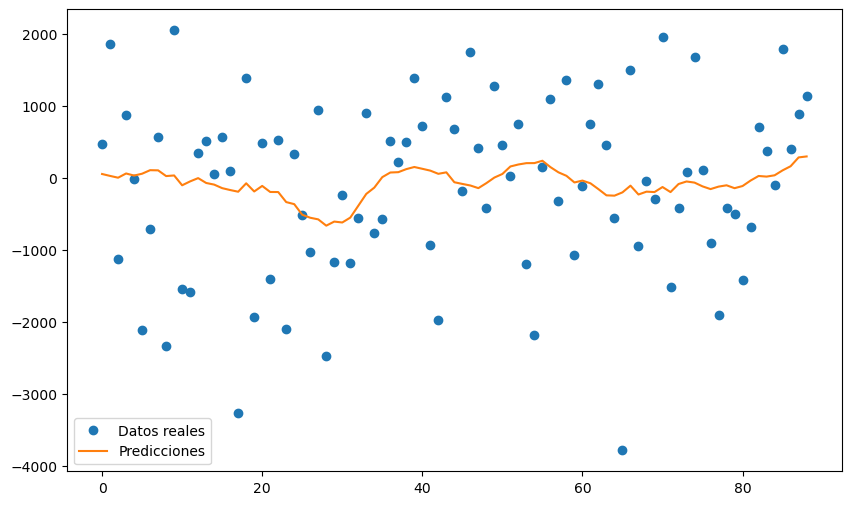

In [574]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define a range of alpha values you want to test
alpha_values = np.logspace(-6, 6, 1000)  # Adjust as needed

# Create a pipeline with StandardScaler and Ridge regression
pipe = make_pipeline(MinMaxScaler(), Ridge())

# Define the parameter grid for the Ridge regression
param_grid = {'ridge__alpha': alpha_values}

# Create the GridSearchCV object
ridge_grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)

# Fit the model to your training data
ridge_grid.fit(residuales_train_extra, residuals_train)


# Evalúa el modelo en datos de prueba escalados
y_pred_ridge = ridge_grid.predict(residuales_test_extra)

# Grafica los resultados
plt.figure(figsize=(10, 6))
plt.plot(residuales_AR, label='Datos reales', marker='o', linestyle='' )
plt.plot(y_pred_ridge, label='Predicciones')
plt.legend()
plt.show()



In [575]:
#metricas(residuales_AR, y_pred_ridge)

In [576]:

y_AR_Ridge = predictions_AR + y_pred_ridge

##### Metricas del modelo

In [577]:
nueva_fila = metricas(test, y_AR_Ridge, 'AR-Ridge')
df_resultados = df_resultados.append(nueva_fila, ignore_index=True)
print(df_resultados)

      Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0         AR   968.170  0.188           0.697                           0.697
1       ARMA   848.461  0.169           0.757                           0.757
2      Ridge  1131.050  0.220           0.587                           0.587
3      Lasso  1130.720  0.220           0.586                           0.586
4         RF  1167.635  0.233           0.534                           0.534
5       k-NN  1174.654  0.234           0.531                           0.531
6        SVR  1303.934  0.251           0.461                           0.461
7        MLP  1237.249  0.238           0.514                           0.514
8      AR-RF   906.356  0.179           0.726                           0.726
9    ARMA-RF   825.405  0.163           0.772                           0.772
10  AR-Ridge   919.829  0.181           0.721                           0.721


### ARMA-MODEL

Text(0, 0.5, 'Caudal (m3/s)')

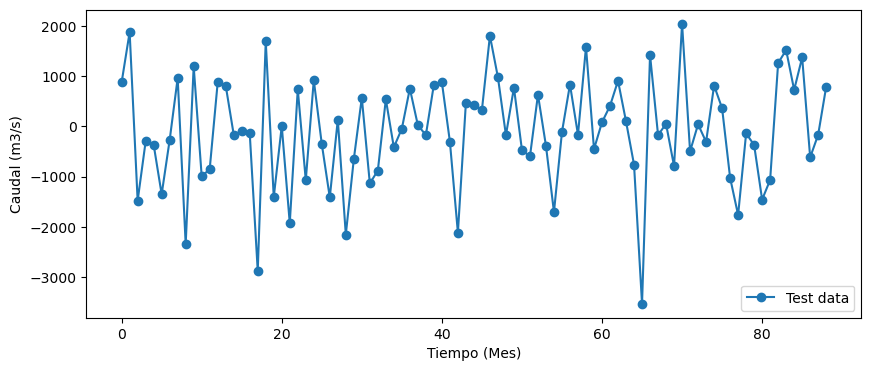

In [578]:
fig = plt.figure(figsize=(10, 4))
plt.plot(residuales_ARMA, marker='o', label="Test data")
#plt.plot(data_test.Mes, y_pred, label="RF")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Agregamos nombres a los ejes
plt.xlabel("Tiempo (Mes)")  # Nombre del eje x
plt.ylabel("Caudal (m3/s)")  # Nombre del eje y


In [579]:
best_order = orden_arma
history = [x for x in train]
model = ARIMA(history, order=best_order)
model_fit = model.fit()

residuals_train = model_fit.resid

residuales_train_lag = np.roll(residuals_train, shift=1)
#residuales_train_extra = residuales_train_lag
residuales_train_extra = np.column_stack((residuales_train_lag, X_train[:, 1]))

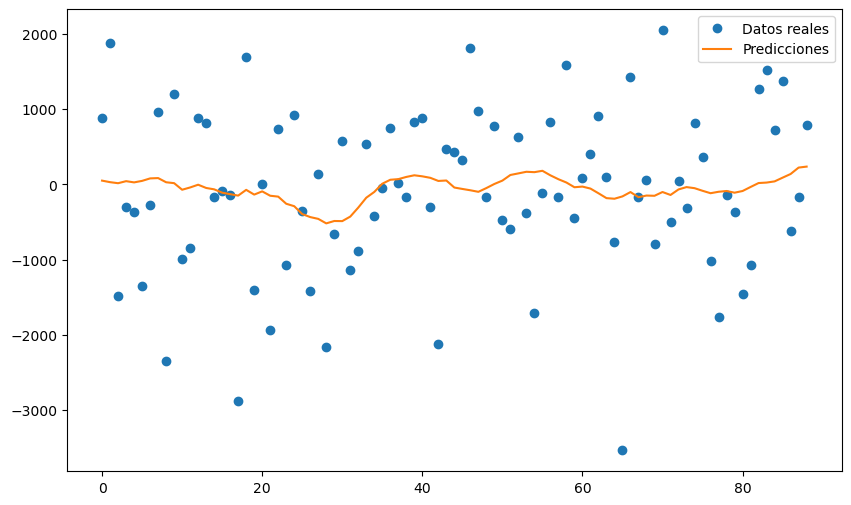

In [580]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define a range of alpha values you want to test
alpha_values = np.logspace(-6, 6, 1000)  # Adjust as needed

# Create a pipeline with StandardScaler and Ridge regression
pipe = make_pipeline(MinMaxScaler(), Ridge())

# Define the parameter grid for the Ridge regression
param_grid = {'ridge__alpha': alpha_values}

# Create the GridSearchCV object
ridge_grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)

# Fit the model to your training data
ridge_grid.fit(residuales_train_extra, residuals_train)


# Evalúa el modelo en datos de prueba escalados
y_pred_ridge = ridge_grid.predict(residuales_test_extra)

# Grafica los resultados
plt.figure(figsize=(10, 6))
plt.plot(residuales_ARMA, label='Datos reales', marker='o', linestyle='' )
plt.plot(y_pred_ridge, label='Predicciones')
plt.legend()
plt.show()



In [581]:
#metricas(residuales_ARMA, y_pred_ridge)


In [582]:

y_ARMA_Ridge = predictions_ARMA + y_pred_ridge


##### Metricas del modelo

In [583]:
nueva_fila = metricas(test, y_ARMA_Ridge, 'ARMA-Ridge')
df_resultados = df_resultados.append(nueva_fila, ignore_index=True)
print(df_resultados)

        Modelo       MAE  RRMSE R-squared (R^2)  \
0           AR   968.170  0.188           0.697   
1         ARMA   848.461  0.169           0.757   
2        Ridge  1131.050  0.220           0.587   
3        Lasso  1130.720  0.220           0.586   
4           RF  1167.635  0.233           0.534   
5         k-NN  1174.654  0.234           0.531   
6          SVR  1303.934  0.251           0.461   
7          MLP  1237.249  0.238           0.514   
8        AR-RF   906.356  0.179           0.726   
9      ARMA-RF   825.405  0.163           0.772   
10    AR-Ridge   919.829  0.181           0.721   
11  ARMA-Ridge   829.085  0.164           0.770   

   NSE (Nash-Sutcliffe Efficiency)  
0                            0.697  
1                            0.757  
2                            0.587  
3                            0.586  
4                            0.534  
5                            0.531  
6                            0.461  
7                            0.514  
8  

# Resultados

A continuación se muestra la tabla resumen de todos los modelos implementados y las metricas calculadas.

In [584]:
df_resultados

,Modelo,MAE,RRMSE,R-squared (R^2),NSE (Nash-Sutcliffe Efficiency)
0,AR,968.170,0.188,0.697,0.697
1,ARMA,848.461,0.169,0.757,0.757
2,Ridge,1131.050,0.220,0.587,0.587
3,Lasso,1130.720,0.220,0.586,0.586
4,RF,1167.635,0.233,0.534,0.534
5,k-NN,1174.654,0.234,0.531,0.531
6,SVR,1303.934,0.251,0.461,0.461
7,MLP,1237.249,0.238,0.514,0.514
8,AR-RF,906.356,0.179,0.726,0.726
9,ARMA-RF,825.405,0.163,0.772,0.772
